# RFD2-MI

We recommend creating two directories to perform this computational design pipeline.

Directory 1: `home_dir` to store all command-writing scripts, job submission scripts and analysis scripts. The role of the `Zn_protease` repository is `home_dir`.

Directory 2: `scratch_dir` to store all data output in the intermediate steps of the computational pipeline. We recommend a storage space limit of 5 TB and file number limit of 25 million for the entire computational pipeline.  

In [48]:
import itertools
import os

## define permutations
perm_YEs = ["A315-317","A376-378"] ## permute the tyrosine and the glutamate (third zinc chelator)
perm_HBs = ["A64-66","A293-297"] ## permute the HEXXH helix and the edge strand beta sheet

contigs_chainA=[]
for perm_YE in itertools.permutations(perm_YEs):
    for perm_HB in itertools.permutations(perm_HBs):
        contigs_chainA.append(f"15-100,{perm_HB[0]},10-100,{perm_HB[1]},25-100,{perm_YE[0]},25-100,{perm_YE[1]},15-100")
        contigs_chainA.append(f"15-100,{perm_YE[0]},25-100,{perm_YE[1]},25-100,{perm_HB[0]},10-100,{perm_HB[1]},15-100")
        
    
contigs_chainA        

['15-100,A64-66,10-100,A293-297,25-100,A315-317,25-100,A376-378,15-100',
 '15-100,A315-317,25-100,A376-378,25-100,A64-66,10-100,A293-297,15-100',
 '15-100,A293-297,10-100,A64-66,25-100,A315-317,25-100,A376-378,15-100',
 '15-100,A315-317,25-100,A376-378,25-100,A293-297,10-100,A64-66,15-100',
 '15-100,A64-66,10-100,A293-297,25-100,A376-378,25-100,A315-317,15-100',
 '15-100,A376-378,25-100,A315-317,25-100,A64-66,10-100,A293-297,15-100',
 '15-100,A293-297,10-100,A64-66,25-100,A376-378,25-100,A315-317,15-100',
 '15-100,A376-378,25-100,A315-317,25-100,A293-297,10-100,A64-66,15-100']

In [51]:
import glob
cmd_file = "/scratch_dir/diffusion/cmd_test_4qhp"
cmd_content = ""
input_pdb =  "/home_dir/motif/4qhp_motif_astacin_substrate_strand_pair.pdb"
output_dir = "/scratch_dir/diffusion/"
os.makedirs(output_dir,exist_ok=True)

num_designs=125

for i in range(25):
    for idxA,contig_A in enumerate(contigs_chainA):

        output_name = os.path.basename(input_pdb)[:-4]+"contigA_" + str(idxA) +"_"+str(i)
        output_prefix = os.path.join(output_dir, output_name)


        cmd_content += f"""/path/to/rfd2mi/run_inference.py --config-name=aa_ppi \
        inference.ckpt_path=/databases/lab/aa-diffusion/models/ppi_robust_struct_RFD_22.pt \
        inference.custom_t_range=[50,49,48,47,46,45,44,43,42,41,40,38,36,34,32,30,27,23,20,17,14,10,7,4,1] \
        contigmap.length=180-220 \
        upstream_inference_transforms.configs.RenumberCroppedInput.enabled=False \
        inference.silent_out=False \
        inference.num_designs={num_designs} \
        inference.ligand='"ZN"' \
        inference.input_pdb={input_pdb} \
        contigmap.contigs=["'{contig_A},0_3-5,B3-5,2-2'"] \
        diffuser.T=50 \
        inference.write_extra_ts=[30,20,10] \
        ppi.hotspot_res='"ZN:ZN"' \
        inference.output_prefix={output_dir}/{output_name} \
        inference.write_trajectory=False \
        inference.write_trb_indep=False \
        diffuser.rots.exp_rate=10 \
        inference.deterministic=False \n"""



with open(cmd_file, "w") as f:
    f.write(cmd_content)
    
## for guideposts the seq cannot be inpainted. 

In [55]:
# Define the SLURM job script parameters
import os
working_dir ="/scratch_dir/diffusion"
command_file_path = "/scratch_dir/diffusion/cmd_test_4qhp"
log_dir = os.path.join(working_dir, "log")
# Define directories

group_size = 1  

# Count the total number of commands in the cmds_chai file
with open(command_file_path, 'r') as cmd_file:
    total_commands = len(cmd_file.readlines())

# Calculate the job array range
job_array_range = total_commands // group_size + (1 if total_commands % group_size != 0 else 0)

# Create a log directory inside the working directory (if not exists)
os.makedirs(log_dir, exist_ok=True)

# Define the SLURM job script parameters
slurm_script_path = os.path.join(working_dir, "submit_diffusion.sh")

# Generate the SLURM script
slurm_script = f"""#!/bin/bash
#SBATCH --mail-type=BEGIN
#SBATCH --mail-type=END
#SBATCH --mail-user=achen918
#SBATCH -p gpu-bf
#SBATCH --gres=gpu:1
#SBATCH -c 2
#SBATCH --mem=8G
#SBATCH -t 05:00:00
#SBATCH -o {log_dir}/q%a.log
#SBATCH -a 1-{job_array_range}
squeue 
GROUP_SIZE={group_size}

for I in $(seq 1 $GROUP_SIZE)
do
    J=$(($SLURM_ARRAY_TASK_ID * $GROUP_SIZE + $I - $GROUP_SIZE))
    CMD=$(sed -n "${{J}}p" {command_file_path})
    echo "${{CMD}}" | bash
done
"""

# Write the SLURM script to a file
with open(slurm_script_path, 'w') as slurm_file:
    slurm_file.write(slurm_script)

    
print(f"SLURM submit script saved at: {slurm_script_path}")

SLURM submit script saved at: /net/scratch/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/diffusion/submit_diffusion.sh


# Benchmark bb

In [2]:
import argparse
import os
import math
import glob

def create_slurm_script(script_path, csv_file, bb_dir, num_jobs, pdbs_per_job,log_dir,out_dir):
    script = f"""#!/bin/bash
#SBATCH -p cpu
#SBATCH --mem=16g
#SBATCH -c 1
#SBATCH -J benchmarl_bb
#SBATCH -o {log_dir}/out.log%a
#SBATCH -t 00:30:00
#SBATCH -a 1-{num_jobs}

# Calculate start and end indices for this job
start_idx=$(( ($SLURM_ARRAY_TASK_ID - 1) * {pdbs_per_job} + 1 ))
end_idx=$(( $SLURM_ARRAY_TASK_ID * {pdbs_per_job} ))

# Create a temporary directory for this job
temp_dir="{out_dir}/tmp/$SLURM_JOB_ID"
mkdir -p $temp_dir

# Process the subset of PDBs for this job
/software/containers/PPI_design.sif {script_path} $temp_dir/output_$SLURM_ARRAY_TASK_ID.csv "{bb_dir}" --start $start_idx --end $end_idx

"""
    return script

def main():
    parser = argparse.ArgumentParser(description="Generate SLURM submission script for PDB processing.")
    working_dir = "/scratch_dir//filter_bb"
    os.makedirs(working_dir,exist_ok=True)
    csv_file = working_dir + "/benchmark.csv"
    out_dir = working_dir +"/parallel_benchmark"
    os.makedirs(out_dir,exist_ok=True)
    bb_dir ="/scratch_dir/diffusion"
    log_dir = working_dir +"/log"
    os.makedirs(log_dir,exist_ok=True)
    script_path = "/home_dir/filter_bb/benchmark.py"
    submit_script = os.getcwd()+"/filter_bb/submit_benchmark.sh"
    num_pdbs = len(glob.glob(bb_dir + "/*.pdb"))
    print(f"found {num_pdbs} pdbs")
    pdbs_per_job = 50
    num_jobs = math.ceil(num_pdbs /pdbs_per_job )
    script = create_slurm_script(script_path,
                                 csv_file, 
                                 bb_dir, 
                                 num_jobs, 
                                 pdbs_per_job,
                                 log_dir,
                                 out_dir)

    with open(submit_script, "w") as f:
        f.write(script)

    print(f"SLURM submit: sbatch {submit_script}")

if __name__ == "__main__":
    main()


found 87657 pdbs
SLURM submit: sbatch /home/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/filter_bb/submit_benchmark.sh


In [3]:
working_dir = "/scratch_dir//filter_bb"
csv_file = working_dir + "/benchmark.csv"
out_dir = working_dir + "/parallel_benchmark/tmp"
concatenating_command = f"cat {out_dir}/*/output_*.csv > {csv_file}"
print('concatenate all processed csv files:\n',concatenating_command)
print('\nIf you see *~ files, simply check the .csv file and do rm *~')

concatenate all processed csv files:
 cat /net/scratch/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion//filter_bb_strand_pair_substrate/parallel_benchmark/tmp/*/output_*.csv > /net/scratch/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion//filter_bb_strand_pair_substrate/benchmark.csv

If you see *~ files, simply check the .csv file and do rm *~


In [4]:
### analyze benchmark
import os
import pandas as pd
def has_consecutive(sequence, char, count):
    """
    Function to check if there are more than a specified number of a character in a row
    """
    return char * count in sequence
    
pd.set_option('display.max_colwidth', None)
working_dir = "/scratch_dir//filter_bb"
csv_file = working_dir + "/benchmark.csv"
df = pd.read_csv(csv_file)
df=df[df["file_name"]!="file_name"].reset_index(drop=True)
df["file_path"] = df["file_path"]
df["long_loop"] = df["dssp_sequence"].apply(lambda x: has_consecutive(x, 'L', 8))
df.iloc[15:22]


,file_name,H,S,L,X,dssp_sequence,floating_sidechain,cat_residue_in_peptide,chain_break,largest_opening_angle,file_path,long_loop
15,4qhp_motif_astacin_substrate_strand_paircontigA_7_9_78-atomized-bb-False_t30.pdb,0.37745097279548645,0.27450981736183167,0.3480392098426819,0.0,LSSSSSLLHHHHHHHHHHHHHHHHHLLLLLLLLLSSSSSLLLLLSSSSSSLLLHHHHHHHHHHHLLSSSSSSSSHHHHHHHHHHHLLLLLLLLLLSSSSLLLLLLSSSSSSSSLLLHHHHHHHHHHHHLLLLSSSSLLLLLSSSSSLLLHHHHHHHHHHHHHHLLLLLHHHHHHHHHHHHLLSSSSSLLLLLLLSSSSSSLLLL,False,False,False,8.362829220028894,/net/scratch/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/diffusion/4qhp_motif_astacin_substrate_strand_paircontigA_7_9_78-atomized-bb-False_t30.pdb,True
16,4qhp_motif_astacin_substrate_strand_paircontigA_7_9_79-atomized-bb-False.pdb,0.4254143536090851,0.18232044577598572,0.3922652006149292,0.0,LHHHHHHHHHLLHHHHHHHHHHLLHHHHHHHHHLLLSSSSSLLLLLLSSSSSSSSLLLLLHHHHHHHHHHHHHLLLLLLSSSSLLLLLLLSSSSLLLLLLHHHHHHHHHHHHHHLLLLLLLLLLSSSSSSSLLLLLLLLLLLLSSSSSLLLLLLLLLLHHHHHHHHHHHHHHHHHHHHHHL,False,False,False,7.501986321383557,/net/scratch/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/diffusion/4qhp_motif_astacin_substrate_strand_paircontigA_7_9_79-atomized-bb-False.pdb,True
17,4qhp_motif_astacin_substrate_strand_paircontigA_7_9_79-atomized-bb-False_t10.pdb,0.41436463594436646,0.2983425557613373,0.28729280829429626,0.0,LHHHHHHHHHLLHHHHHHHHHHLLLHHHHHHHHLLLSSSSSSSSLLLSSSSSSSSLLLLLHHHHHHHHHHHHLLLLLLLSSSSLLLLLLSSSSSSLLLLLHHHHHHHHHHHHHHLLLLLLLLLLSSSSSSSLSSSSSSSSLLLSSSSSLSSSSSSSSLHHHHHHHHHHHHHHHHHHHHHHL,False,False,False,7.286314257610283,/net/scratch/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/diffusion/4qhp_motif_astacin_substrate_strand_paircontigA_7_9_79-atomized-bb-False_t10.pdb,True
18,4qhp_motif_astacin_substrate_strand_paircontigA_7_9_79-atomized-bb-False_t20.pdb,0.41988950967788696,0.31491711735725403,0.265193372964859,0.0,LHHHHHHHHHLLHHHHHHHHHHLLLHHHHHHHHLSSSSSSSSSSLLLSSSSSSSSLLLLLHHHHHHHHHHHHLLLLLLLSSSSLLLLLLSSSSSSLLLLLHHHHHHHHHHHHHHHLLLLLLLLLSSSSSSSLSSSSSSSSLLLSSSSSSSSSSSSSSLHHHHHHHHHHHHHHHHHHHHHHL,False,False,False,7.203803996761293,/net/scratch/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/diffusion/4qhp_motif_astacin_substrate_strand_paircontigA_7_9_79-atomized-bb-False_t20.pdb,True
19,4qhp_motif_astacin_substrate_strand_paircontigA_7_9_79-atomized-bb-False_t30.pdb,0.41988950967788696,0.32044199109077454,0.2596684992313385,0.0,LHHHHHHHHHLLHHHHHHHHHHLLLHHHHHHHLLSSSSSSSSSSLLLSSSSSSSSSLLLLHHHHHHHHHHHHLLLLLLLSSSSLLLLLLSSSSSSLLLLLHHHHHHHHHHHHHHHHSSSLLLLLLSSSSSSLLSSSSSSSLLLSSSSSSLSSSSSSSLHHHHHHHHHHHHHHHHHHHHHHL,False,False,False,7.176471345134483,/net/scratch/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/diffusion/4qhp_motif_astacin_substrate_strand_paircontigA_7_9_79-atomized-bb-False_t30.pdb,False
20,4qhp_motif_astacin_substrate_strand_paircontigA_7_9_8-atomized-bb-False.pdb,0.6529411673545837,0.08235294371843338,0.2647058963775635,0.0,LSSSSSSSLLLSSSSSSSLHHHHHHHHLLLLLLHHHHHHHHHHHHHHLLLLLLLLLLLLHHHHHHHHHHHHHHHHHHHHHHHHHHHHLLLLLLHHHHHHHHHHHHHLLHHHHHHHHHHHHHHHHHHHHHHLLLLHHHHHHHHHHHHHHHLLLLLLLLLHHHHHHHHHHHL,False,False,True,13.781996057341495,/net/scratch/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/diffusion/4qhp_motif_astacin_substrate_strand_paircontigA_7_9_8-atomized-bb-False.pdb,True
21,4qhp_motif_astacin_substrate_strand_paircontigA_7_9_8-atomized-bb-False_t10.pdb,0.6411764621734619,0.11176470667123795,0.24705882370471954,0.0,LSSSSSSSLLLSSSSSSSLHHHHHHHLLLLLLLHHHHHHHHHHHHHHLLLLLLLLLLLLHHHHHHHHHHHHHHHHHHHHHHHHHHHHLLLLLLHHHHHHHHHHHHHLLHHHHHHHHHHHHHHHHHHHHHHHLLLHHHHHHHHHHHHHLLLLLSSSSSLHHHHHHHHHHHL,False,False,False,21.547244025061755,/net/scratch/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/diffusion/4qhp_motif_astacin_substrate_strand_pairco

In [5]:
## filter

import os
import shutil
import glob
working_dir = "/scratch_dir/filter_bb"
filtered_bb_dir = working_dir +"/filtered_bbs"
# Create the destination folder if it doesn't exist
os.makedirs(filtered_bb_dir , exist_ok=True)


condition = (df["cat_residue_in_peptide"] == "False") & \
            (df["chain_break"] == "False")  &\
            (df["floating_sidechain"] == "False") & \
            (df["long_loop"].apply(lambda x: x==False)) &\
            (df["largest_opening_angle"].apply(lambda x: float(x)>25)) 

print(f"number of passing designs: {len(df[condition])}")

# Copy each file to the destination folder
for i, file_path in enumerate(df[condition]['file_path']):
    dest_path = os.path.join(filtered_bb_dir, os.path.basename(file_path))
    if "all_potential_bbs_run.pdb_test_run.pdb" in file_path:
        continue
    if not os.path.exists(dest_path):  # Check if the file already exists
        shutil.copy(file_path, filtered_bb_dir)  # Copy only if it doesn't exist
        
    if i % 1000 == 0:
        print(f"{i} Files copied to 'filtered_bbs' folder.")
        
num_filtered_bbs = len(glob.glob(f"{filtered_bb_dir}/*.pdb"))
print(f"{num_filtered_bbs} Files copied to 'filtered_bbs' folder.")

number of passing designs: 6293
0 Files copied to 'filtered_bbs' folder.
1000 Files copied to 'filtered_bbs' folder.
2000 Files copied to 'filtered_bbs' folder.
3000 Files copied to 'filtered_bbs' folder.
4000 Files copied to 'filtered_bbs' folder.
5000 Files copied to 'filtered_bbs' folder.
6000 Files copied to 'filtered_bbs' folder.
5226 Files copied to 'filtered_bbs' folder.


# Enhanced mpnn FR

In [9]:

import os
import math

def generate_slurm_script(script, 
                          save_relaxed_cycles, 
                          num_relax_cycles, 
                          input_pdb_dir, 
                          cst_dir, 
                          working_dir, 
                          slurm_script_path, 
                          num_pdbs_per_job, 
                          rosetta_xml_path,
                          omit_AA_json_dir,
                          time='02:00:00', mem='4g'):
    log_dir = os.path.join(working_dir, 'log')
    os.makedirs(log_dir, exist_ok=True)
    
    # Count total PDB files
    total_pdbs = len([f for f in os.listdir(input_pdb_dir) if f.endswith('.pdb')])
    
    num_tasks = math.ceil(total_pdbs / num_pdbs_per_job)
    
    print(f"the total number of pdbs is {total_pdbs}")
    print(f"the total number of tasks is {num_tasks}")
    
    slurm_script = f"""#!/bin/bash
#SBATCH -p cpu
#SBATCH --mem={mem}
#SBATCH -c 1
#SBATCH -J enhanced_mpnn_fr
#SBATCH -o {log_dir}/enhanced_mpnn_fr_%A_%a.out
#SBATCH -t {time}
#SBATCH -a 0-{num_tasks-1}

# Set variables
INPUT_PDB_DIR="{input_pdb_dir}"
CST_DIR="{cst_dir}"
WORKING_DIR="{working_dir}"
ROSETTA_XML="{rosetta_xml_path}"
OMIT_AA_JSON_DIR="{omit_AA_json_dir}"

# Calculate indices
START_INDEX=$((SLURM_ARRAY_TASK_ID * {num_pdbs_per_job}))
END_INDEX=$((START_INDEX + {num_pdbs_per_job} - 1))

# Ensure END_INDEX doesn't exceed total PDB count
if [ $END_INDEX -ge {total_pdbs} ]; then
    END_INDEX=$(({total_pdbs} - 1))
fi

source activate my-pyrosetta 
# Run the Python script
python {script} {save_relaxed_cycles} {num_relax_cycles} "$ROSETTA_XML" "$INPUT_PDB_DIR" "$CST_DIR" "$WORKING_DIR" $START_INDEX $END_INDEX "$OMIT_AA_JSON_DIR"
"""    
    with open(slurm_script_path, "w") as f:
        f.write(slurm_script)
    
    print(f"SLURM script generated: {slurm_script_path}")
    print("You can now submit the job with:")
    print(f"sbatch {slurm_script_path}")

# Example usage
save_relaxed_cycles=True
num_relax_cycles=10
input_pdb_dir = '/scratch_dir/filter_bb/filtered_bbs'
cst_dir = '/scratch_dir/enhanced_mpnn_fr'+ '/cst_files'
working_dir = '/scratch_dir/enhanced_mpnn_fr'  ## an /mpnn_output dir will be created under this dir.
slurm_script_path = os.getcwd() + '/enhanced_mpnn_fr/submit_enhanced_mpnn_fr.sh'
num_pdbs_per_job = 1
script = os.getcwd() + "/enhanced_mpnn_fr/enhanced_mpnn_fr.py"
rosetta_xml_path = os.getcwd() + "/enhanced_mpnn_fr/RosettaFastRelaxUtil_cst.xml"
omit_AA_json_dir = os.getcwd() + "/enhanced_mpnn_fr/ban_DEH_from_zinc"


generate_slurm_script(
    script, 
    save_relaxed_cycles,
    num_relax_cycles,
    input_pdb_dir,
    cst_dir,
    working_dir,
    slurm_script_path,
    num_pdbs_per_job,
    rosetta_xml_path,
    omit_AA_json_dir
)

    


the total number of pdbs is 5226
the total number of tasks is 5226
SLURM script generated: /home/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/enhanced_mpnn_fr/submit_enhanced_mpnn_fr.sh
You can now submit the job with:
sbatch /home/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/enhanced_mpnn_fr/submit_enhanced_mpnn_fr.sh


# AF3

In [1]:
import os
import glob
import json
from Bio.PDB import MMCIFParser

# Amino acid mapping from 3-letter to 1-letter code
aa_map = {
    "ALA": "A", "ARG": "R", "ASN": "N", "ASP": "D", "CYS": "C",
    "GLN": "Q", "GLU": "E", "GLY": "G", "HIS": "H", "ILE": "I",
    "LEU": "L", "LYS": "K", "MET": "M", "PHE": "F", "PRO": "P",
    "SER": "S", "THR": "T", "TRP": "W", "TYR": "Y", "VAL": "V"
}



def extract_sequence_from_pdb(pdb_file, chain_id):
    """Extracts the sequence of a given chain from a PDB file."""
    sequence = []
    seen_residues = set()

    with open(pdb_file, 'r') as file:
        for line in file:
            if line.startswith("ATOM") and line[21] == chain_id:  # Column 22 is Chain ID
                res_name = line[17:20].strip()  # Column 18-20 is Residue Name
                res_id = line[22:26].strip()    # Column 23-26 is Residue Number
                
                if (res_id not in seen_residues) and (res_name in aa_map):
                    seen_residues.add(res_id)
                    sequence.append(aa_map[res_name])
    
    return "".join(sequence)


# Define directories
working_dir = "/scratch_dir/af3_monomer"
input_dir = "/scratch_dir/enhanced_mpnn_fr/mpnn_output/*/" # all mpnn seqs are used
json_dir = f'{working_dir}/json_files'
output_dir = f'{working_dir}/output'

# Ensure output directories exist
os.makedirs(working_dir, exist_ok=True)
os.makedirs(json_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

# File path for the output command list
command_file_path = os.path.join(working_dir, 'cmds_af3_monomer')



# Open the command file for writing
with open(command_file_path, 'w') as cmd_file:
    pdb_count = 0  # To track how many PDB files are processed

    # Use glob to match PDB files ending with ".pdb"
    pdb_files = glob.glob(os.path.join(input_dir, "*.pdb"))

    for pdb_file in pdb_files:
        pdb_count += 1
        pdb_name = os.path.splitext(os.path.basename(pdb_file))[0]

        # Extract sequences for Chain A and Chain B
        chain_A_sequence = extract_sequence_from_pdb(pdb_file, "A")
        

        # Construct JSON content
        json_data = [{
            "name": pdb_name,
            "sequences": [
                {"protein": {
                    "id": "A",
                    "sequence": chain_A_sequence,
                    "unpairedMsa": "",
                    "pairedMsa": "",
                    "templates": ""
                }},
            ],
            "modelSeeds": [1],
            "dialect": "alphafold3",
            "version": 1
        }]


        # Define JSON file path
        json_file_path = os.path.join(json_dir, f"{pdb_name}.json")

        # Save JSON file in a single line
        with open(json_file_path, 'w') as json_file:
            json.dump(json_data, json_file, separators=(',', ':'))

        # Generate the command for this PDB (Fixed json_path reference)
        cmd = f"""
###CMD###
#!/bin/bash

# Define paths
JSON_PATH="{json_file_path}"
OUTPUT_DIR="{output_dir}"

# 1. Get base folder name in lowercase
BASE_NAME=$(basename "$JSON_PATH" .json | tr '[:upper:]' '[:lower:]')

# 2. Define expected output folder path
EXPECTED_FOLDER="$OUTPUT_DIR/$BASE_NAME"

# 3. Check if folder exists and contains .cif files
if [ -d "$EXPECTED_FOLDER" ] && ls "$EXPECTED_FOLDER"/*.cif >/dev/null 2>&1; then
    echo "Skipping: Output exists at $EXPECTED_FOLDER with .cif file(s)"
else
    echo "Running AlphaFold3 prediction..."
    /software/containers/users/ikalvet/mlfold3/mlfold3_01.sif python \
    /opt/alphafold3/run_alphafold_custom.py \
    --json_path="$JSON_PATH" \
    --output_dir="$OUTPUT_DIR"
fi

"""
        

        # Write the command to the file
        cmd_file.write(cmd)
        if pdb_count %100 ==0:
            print(f"processed {pdb_count} files in {len(pdb_files)} files")

    # Check if no sequences were processed
    if pdb_count == 0:
        print(f"No PDB files ending with '.pdb' found in {input_dir}")

# Print summary
if pdb_count > 0:
    print(f"Processed {pdb_count} PDB files.")
    print(f"Command list saved to {command_file_path}")


processed 100 files in 80664 files
processed 200 files in 80664 files
processed 300 files in 80664 files
processed 400 files in 80664 files
processed 500 files in 80664 files
processed 600 files in 80664 files
processed 700 files in 80664 files
processed 800 files in 80664 files
processed 900 files in 80664 files
processed 1000 files in 80664 files
processed 1100 files in 80664 files
processed 1200 files in 80664 files
processed 1300 files in 80664 files
processed 1400 files in 80664 files
processed 1500 files in 80664 files
processed 1600 files in 80664 files
processed 1700 files in 80664 files
processed 1800 files in 80664 files
processed 1900 files in 80664 files
processed 2000 files in 80664 files
processed 2100 files in 80664 files
processed 2200 files in 80664 files
processed 2300 files in 80664 files
processed 2400 files in 80664 files
processed 2500 files in 80664 files
processed 2600 files in 80664 files
processed 2700 files in 80664 files
processed 2800 files in 80664 files
p

In [2]:
# Define the SLURM job script parameters
# complex_cmd_file_path="/net/scratch/achen918/catalytic_binders/250524_largescale_arginine_final_filter_for_order/af3_complex/cmds_af3_complex"

working_dir = "/scratch_dir//af3_monomer"
os.makedirs(working_dir,exist_ok=True)
# Combine all three command files into a temporary file
command_file_path ="/scratch_dir/af3_monomer/cmds_af3_monomer"

log_dir = os.path.join(working_dir, "af3_log")

group_size = 200  # Set your group size here ## 90s per mpnn seq. about 5 hr for 200 predictions, 

# Count actual commands using bash script markers
with open(command_file_path, 'r') as cmd_file:
    total_commands = 0
    in_command = False
    for line in cmd_file:
        if line.startswith('#!/bin/bash'):
            total_commands += 1
            in_command = True
        elif in_command and line.strip() == 'fi':
            in_command = False

# Calculate the job array range (same as before)
job_array_range = total_commands // group_size + (1 if total_commands % group_size != 0 else 0)

# Create log directory
os.makedirs(log_dir, exist_ok=True)

# Define the SLURM job script parameters
slurm_script_path = os.path.join(working_dir, "submit_af3.sh")

# Modified SLURM script template
slurm_script = f"""#!/bin/bash
#SBATCH --mail-type=BEGIN
#SBATCH --mail-type=END
#SBATCH --mail-user=achen918
#SBATCH -p gpu
#SBATCH --gres=gpu:a4000:1
#SBATCH -c 2
#SBATCH --mem=16G
#SBATCH -t 05:00:00
#SBATCH -o {log_dir}/q%a.log
#SBATCH -a 1-{job_array_range}

GROUP_SIZE={group_size}

for I in $(seq 1 $GROUP_SIZE)
do
    J=$(($SLURM_ARRAY_TASK_ID * $GROUP_SIZE + $I - $GROUP_SIZE))
    
    # Extract command block using awk
    CMD=$(awk -v cmd_num="$J" '
        /^###CMD###/ {{ if (++count == cmd_num) {{ flag=1; next }} }}
        flag {{ if (/^###CMD###/) {{ flag=0 }} else {{ print }} }}
    ' {command_file_path})
    
    if [ -n "$CMD" ]; then
        echo "Running command $J:"
        echo "$CMD" | bash
    fi
done
"""

# Write the SLURM script to a file
with open(slurm_script_path, 'w') as slurm_file:
    slurm_file.write(slurm_script)

print(f"SLURM submit script saved at: {slurm_script_path}")

SLURM submit script saved at: /net/scratch/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion//af3_monomer/submit_af3.sh


# AF3 analysis

## AF3 monomer analysis

In [5]:
import argparse
import os
import math
import glob

def create_slurm_script(script_path, output_act_dir, combined_output_file, num_jobs, pdbs_per_job, log_dir):
    script = f"""#!/bin/bash
#SBATCH -p cpu
#SBATCH --mem=4g
#SBATCH -c 1
#SBATCH -J collect_data_job
#SBATCH -o {log_dir}/out.log%a
#SBATCH -t 01:00:00
#SBATCH -a 1-{num_jobs}

# Create a directory for individual CSV outputs
output_dir="{log_dir}/../parallel_csvs"
mkdir -p $output_dir


# Calculate start and end indices for this job
start_idx=$(( ($SLURM_ARRAY_TASK_ID - 1) * {pdbs_per_job} + 1 ))
end_idx=$(( $SLURM_ARRAY_TASK_ID * {pdbs_per_job} ))

# Run the Python script with the calculated indices
/software/containers/PPI_design.sif {script_path} "{output_act_dir}" $start_idx $end_idx "$output_dir/output_$SLURM_ARRAY_TASK_ID.csv"
"""
    return script

def main():
    working_dir = "/scratch_dir/af3_monomer_analysis"
    os.makedirs(working_dir, exist_ok=True)
    combined_output_file = os.path.join(working_dir, 'af3_data.csv')
    output_act_dir = os.path.join("/scratch_dir/af3_monomer/output")
    
    log_dir = os.path.join(working_dir, "folding_out/logs")
    os.makedirs(log_dir, exist_ok=True)

    # Path to the Python script (collect_data.py)
    script_path = os.path.join(os.getcwd() + "/af3_monomer_analysis", "collect_data.py")

    # Count total number of PDB files (one per folder in output_act_dir)
    num_pdbs = len([d for d in os.listdir(output_act_dir) if os.path.isdir(os.path.join(output_act_dir, d))])
    
    pdbs_per_job = 100  # Change this value based on clusterstatus cpu usage, around 20 s/100 pdbs
    num_jobs = math.ceil(num_pdbs / pdbs_per_job)

    print(f"Found {num_pdbs} PDB folders. Splitting into {num_jobs} jobs with {pdbs_per_job} PDBs per job.")

    slurm_script_content = create_slurm_script(
        script_path=script_path,
        output_act_dir=output_act_dir,
        combined_output_file=combined_output_file,
        num_jobs=num_jobs,
        pdbs_per_job=pdbs_per_job,
        log_dir=log_dir,
    )

    submit_script_path = os.path.join(os.getcwd() + "/af3_monomer_analysis", "submit_collect_data.sh")
    
    with open(submit_script_path, "w") as f:
        f.write(slurm_script_content)

    print(f"SLURM submit script written to: {submit_script_path}")
    print(f"Submit your job with: sbatch {submit_script_path}")

main()


Found 67386 PDB folders. Splitting into 674 jobs with 100 PDBs per job.
SLURM submit script written to: /home/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/af3_monomer_analysis/submit_collect_data.sh
Submit your job with: sbatch /home/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/af3_monomer_analysis/submit_collect_data.sh


In [6]:
import os

# Define paths
working_dir = "/scratch_dir/af3_monomer_analysis/folding_out"
parallel_csv_dir = os.path.join(working_dir, "parallel_csvs")
combined_csv_file = os.path.join(working_dir, "af3_data.csv")

# Combine all individual CSV files into one, removing redundant headers
os.system(f"head -n 1 {parallel_csv_dir}/output_1.csv > {combined_csv_file}")  # Add header from the first file
os.system(f"tail -n +2 -q {parallel_csv_dir}/output_*.csv >> {combined_csv_file}")  # Append data from all files, skipping headers

print(f"Combined CSV written to: {combined_csv_file}")


Combined CSV written to: /net/scratch/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/af3_monomer_analysis/folding_out/af3_data.csv


Number of outputs satisfying filter: 1411 out of 335910 predictions
fraction of outputs satisfying filter: 0.004200529903843292


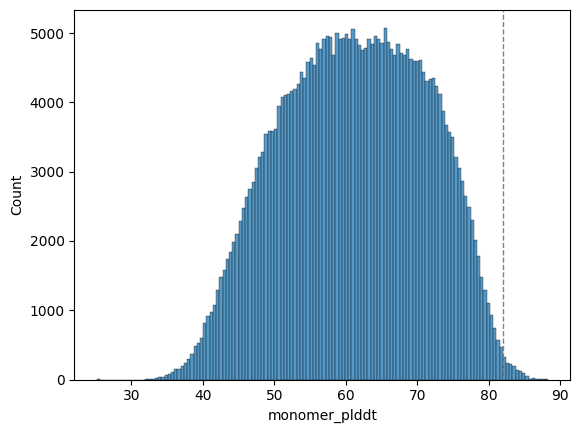

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Define the working directory and load the CSV file
working_dir =  "/scratch_dir/af3_monomer_analysis/folding_out/"
combined_csv_file = os.path.join(working_dir, "af3_data.csv")
filtered_csv_file = os.path.join(working_dir, "af3_folding_filtered.csv")
df = pd.read_csv(combined_csv_file , sep=',')

x_point = 82

# Convert columns to numeric, coerce errors if there are any invalid values
df['monomer_plddt'] = pd.to_numeric(df['monomer_plddt'], errors='coerce')


g = sns.histplot(data=df, x='monomer_plddt')
g.axvline(x=x_point, color='gray', linestyle='dashed', linewidth=1)

# Count filtered output with additional conditions for RMSD values
condition = (
    (df['monomer_plddt'] > x_point) 
)
satisfying_df = df[condition]
count = satisfying_df.shape[0]
print(f'Number of outputs satisfying filter: {count} out of {len(df)} predictions' )
print(f"fraction of outputs satisfying filter: {count/len(df)}")
satisfying_df.to_csv(filtered_csv_file)

## rmsds

In [7]:
import os
import pandas as pd
import math
def generate_slurm_script(input_csv, template_pdb_dir, output_dir, log_dir, num_tasks, time, mem, rmsd_script, cif2pdb_script):
    slurm_script = f"""#!/bin/bash
#SBATCH -p cpu
#SBATCH --mem={mem}
#SBATCH -c 1
#SBATCH -J calculate_geometry
#SBATCH -o {log_dir}/process_data_%A_%a.out
#SBATCH -t {time}
#SBATCH -a 0-{num_tasks-1}

# Set variables
INPUT_CSV="{input_csv}"
TEMPLATE_PDB_DIR="{template_pdb_dir}"
OUTPUT_DIR="{output_dir}"

# Calculate chunk size and indices
TOTAL_ROWS=$(wc -l < "$INPUT_CSV")
CHUNK_SIZE=$(( (TOTAL_ROWS + SLURM_ARRAY_TASK_COUNT - 1) / SLURM_ARRAY_TASK_COUNT ))
START_INDEX=$(( SLURM_ARRAY_TASK_ID * CHUNK_SIZE ))
END_INDEX=$(( START_INDEX + CHUNK_SIZE ))

# Ensure END_INDEX doesn't exceed TOTAL_ROWS
if [ $END_INDEX -gt $TOTAL_ROWS ]; then
    END_INDEX=$TOTAL_ROWS
fi

# Run the Python script
/software/containers/PPI_design.sif {cif2pdb_script} "$INPUT_CSV" $START_INDEX $END_INDEX
/software/containers/PPI_design.sif {rmsd_script} "$INPUT_CSV" "$TEMPLATE_PDB_DIR" "${{OUTPUT_DIR}}/output_${{SLURM_ARRAY_TASK_ID}}.csv" $START_INDEX $END_INDEX
"""
    return slurm_script

def main():
    
    slurm_script = generate_slurm_script(
        input_csv,
        template_pdb_dir,
        output_dir,
        log_dir,
        num_tasks,
        time,
        mem,
        rmsd_script,
        cif2pdb_script
    )

    with open(output_slurm, "w") as f:
        f.write(slurm_script)

    print(f"SLURM script generated: {output_slurm}")
    print("You can now submit the job with:")
    print(f"sbatch {output_slurm}")

if __name__ == "__main__":
    working_directory = "/scratch_dir//af3_monomer_analysis"
    input_csv = f'{working_directory}/folding_out/af3_folding_filtered.csv' 
    template_pdb_dir = "/scratch_dir/filter_bb/filtered_bbs/" 
            
    log_dir = f'{working_directory}/log_catalytic_site_geometry' 
    os.makedirs(log_dir, exist_ok=True)
    output_dir = working_directory + '/rmsd_calculation_output'
    os.makedirs(output_dir , exist_ok=True)
    
    rows_per_task = 500
    num_tasks=math.ceil(len(pd.read_csv(input_csv))/rows_per_task)
    time='02:00:00'
    mem='1g' 
    rmsd_script = f'{os.getcwd()}/af3_monomer_analysis/rmsd_calculation.py' 
    cif2pdb_script = f'{os.getcwd()}/af3_monomer_analysis/convert_modify_pdb.py'
    output_slurm = f'{os.getcwd()}/af3_monomer_analysis/run_array_job_rmsd_calculation.sh' 
    
    main()

SLURM script generated: /home/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/af3_monomer_analysis/run_array_job_rmsd_calculation.sh
You can now submit the job with:
sbatch /home/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/af3_monomer_analysis/run_array_job_rmsd_calculation.sh


In [18]:
## concatenate results
rmsd_csv_path = "/scratch_dir/af3_monomer_analysis/" + os.path.basename(input_csv).split('.csv')[0]+'_distance_rmsd_calculated.csv'
concatenating_command = f"cat {output_dir}/output_*.csv > {rmsd_csv_path}"
print('concatenate all processed csv files:\n',concatenating_command)
print('\nIf you see *~ files, simply check the .csv file and do rm *~')

concatenate all processed csv files:
 cat /net/scratch/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion//af3_monomer_analysis/rmsd_calculation_output/output_*.csv > /net/scratch/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/af3_monomer_analysis/af3_folding_filtered_distance_rmsd_calculated.csv

If you see *~ files, simply check the .csv file and do rm *~


In [114]:

def get_descriptions_with_at_least_n_passes(df, condition, n=3):
    """
    Identify unique 'definition' values in the DataFrame that have at least `n` rows 
    satisfying `condition` among the 5 predictions per definition.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing 'definition' and 'pdb_path' columns.
        condition (pd.Series): A boolean Series indicating which rows satisfy the condition.
        n (int): Minimum number of passing predictions required per definition.

    Returns:
        List[str]: A list of 'definition' values meeting the criteria.
    """
    # Combine df with condition into a single DataFrame with a boolean column for easier grouping
    df = df.copy()
    df['pass_condition'] = condition

    # Group by 'description' and count how many rows pass the condition in each group
    passing_counts = df.groupby('description')['pass_condition'].sum()

    # Select descriptions where the number of passing predictions >= n
    qualified_descriptions = passing_counts[passing_counts >= n].index.tolist()

    return qualified_descriptions

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

csv_monomer = "/scratch_dir/af3_monomer_analysis//af3_folding_filtered_distance_rmsd_calculated.csv"
df_monomer = pd.read_csv(csv_monomer)
df = df_monomer.copy()

## check unique mpnn seqs
df['mpnn_seq_name'] = df['description'].apply(lambda x: x.removeprefix('pred.').split('_seed')[0])
df['diffusion_bb'] = df['mpnn_seq_name'].apply(lambda x: x.split("-atomized-bb-false")[0])

df['monomer_plddt'] = pd.to_numeric(df['monomer_plddt'], errors='coerce')
df = df.dropna(subset=['monomer_plddt'], how='any')

for column in ['monomer_plddt', 'all_res_ca_rmsd', 'cata_res_sc_rmsd', 'cata_res_bb_rmsd']:
    df[column] = df[column].astype(float)

monomer_plddt_thresh = 82
all_res_ca_rmsd_thresh = 2

    
condition = (df['monomer_plddt']> monomer_plddt_thresh) & \
                (df['all_res_ca_rmsd']<all_res_ca_rmsd_thresh )

## print number of predictions and chai seqs that pass filter
print(f"{len(df[condition])} predictions pass filter, {len(df[condition].mpnn_seq_name.unique())} mpnn seqs pass filter")
print(f" {len(df[condition].diffusion_bb.unique())} diffusion_bbs pass filter")

df_monomer_pass = df[condition].copy()
df_monomer_all = df.copy()

# Suppose `df` is your DataFrame and `condition` is your boolean Series (e.g., df['score'] > 0.7)
qualified_defs_monomer = get_descriptions_with_at_least_n_passes(df, condition, n=3)
print(f"Number of qualified descriptions with 3 out of 5 passes: {len(qualified_defs_monomer)}")


683 predictions pass filter, 189 mpnn seqs pass filter
 88 diffusion_bbs pass filter
Number of qualified descriptions with 3 out of 5 passes: 134


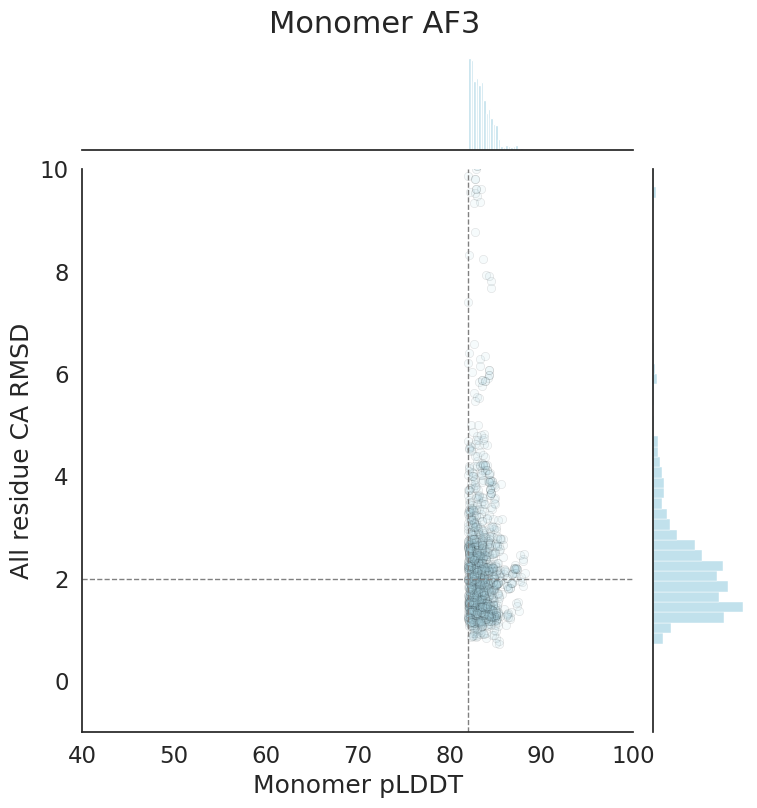

number of predictions satisfying constraints:
683
Number of unique diffusion bbs :
88


In [116]:

# Convert columns to numeric, coerce errors if there are any invalid values

# df = df[df.description.apply(lambda x: "qaqkqaq" in x.lower())]
x_point = 82
y_point = 2 ## 

# Set style
sns.set(style="white", font_scale=1.5)

# Create jointplot
g = sns.jointplot(
    data=df, 
    x='monomer_plddt', 
    y='all_res_ca_rmsd', 
    kind='scatter', 
    color='lightblue', 
    edgecolor='black', 
    alpha=0.1,
    height=8,  # Size of the figure
)

# Add vertical and horizontal lines
g.ax_joint.axvline(x=x_point , color='gray', linestyle='dashed', linewidth=1)
g.ax_joint.axhline(y=y_point , color='gray', linestyle='dashed', linewidth=1)

# Set axis limits
g.ax_joint.set_xlim([40, 100])
g.ax_joint.set_ylim([-1, 10])

# Set labels and title
g.set_axis_labels('Monomer pLDDT', 'All residue CA RMSD', fontsize=18)
g.fig.suptitle('Monomer AF3', y=1.02, fontsize=22)

plt.show()

# Count filtered output with additional conditions for RMSD values
condition = (
    (df['monomer_plddt'] > x_point) &
    (df['all_res_ca_rmsd'] < y_point) 
)

print("number of predictions satisfying constraints:")
print(len(df[condition]))
print("Number of unique diffusion bbs :")
print(df[condition]['diffusion_bb'].nunique())
bb_passing_monomer = df[condition]['diffusion_bb'].unique()


In [11]:
import os
import shutil

# Example setup
target_dir = "/home_dir/af3_monomer_visualization"

# Ensure target_dir exists
os.makedirs(target_dir, exist_ok=True)
satisfying_bb=df[condition].copy()
# Loop through each unique diffusion_bb
for bb in satisfying_bb["diffusion_bb"].unique():
    row = satisfying_bb[satisfying_bb["diffusion_bb"] == bb].iloc[0]
    source_path = row["pdb_path"]
    
    # Check if source file exists
    if not os.path.isfile(source_path):
        print(f"Source file does not exist: {source_path}")
        continue

    # Derive new file name from source path's directory name
    parent_dir = os.path.basename(os.path.dirname(os.path.dirname(source_path)))  # packed folder name
    new_name = f"{parent_dir}_model.pdb"
    new_path = os.path.join(target_dir, new_name)

    # Copy and rename
    shutil.copy(source_path, new_path)
    print(f"Copied: {source_path} -> {new_path}")


Copied: /net/scratch/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/af3_monomer/output/4qhp_motif_astacin_substrate_strand_paircontiga_1_22_22-atomized-bb-false_t20_mpnnfr_cycle_4/seed-1_sample-1/model.pdb -> /home/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/af3_monomer_visualization/4qhp_motif_astacin_substrate_strand_paircontiga_1_22_22-atomized-bb-false_t20_mpnnfr_cycle_4_model.pdb
Copied: /net/scratch/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/af3_monomer/output/4qhp_motif_astacin_substrate_strand_paircontiga_1_23_122-atomized-bb-false_t20_mpnnfr_cycle_5/seed-1_sample-1/model.pdb -> /home/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/af3_monomer_visualization/4qhp_motif_astacin_substrate_strand_paircontiga_1_23_122-atomized-bb-false_t20_mpnnfr_cycle_5_model.pdb
Copied: /net/scratch/achen918/catalytic_binders/2506

## Copy first-round bbs to partial_diffusion_dir 

In [117]:
import os
import shutil
# df[condition]: df is monomer df, condition is monomer plddt > 82 and all residue ca rmsd <2

target_dir = "/net/scratch/achen918/catalytic_binders/250617_motif_aminopeptidase_N_free_diffusion_round2/partial_T/collected_r1_bbs"
bb_dir = "/scratch_dir/filter_bb/filtered_bbs"

r1_bb_names = df[condition]["mpnn_seq_name"].apply(lambda x: x.split("_mpnnfr")[0]).unique()

for name in r1_bb_names:
    # Replace "false" with "False" in the PDB filename
    name = name.replace("false", "False") + ".pdb"
    pdb_name = name.replace("paircontiga", "paircontigA")
    source_path = os.path.join(bb_dir, pdb_name)
    
    new_path = os.path.join(target_dir, "250615_" + pdb_name) ## collec mother bbs of multiple days
    # Copy and rename
    shutil.copy(source_path, new_path)
    print(f"Copied: {source_path} -> {new_path}")

Copied: /net/scratch/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/filter_bb/filtered_bbs/4qhp_motif_astacin_substrate_strand_paircontigA_1_22_22-atomized-bb-False_t20.pdb -> /net/scratch/achen918/catalytic_binders/250617_motif_aminopeptidase_N_free_diffusion_round2/partial_T/collected_r1_bbs/250615_4qhp_motif_astacin_substrate_strand_paircontigA_1_22_22-atomized-bb-False_t20.pdb
Copied: /net/scratch/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/filter_bb/filtered_bbs/4qhp_motif_astacin_substrate_strand_paircontigA_1_23_122-atomized-bb-False_t20.pdb -> /net/scratch/achen918/catalytic_binders/250617_motif_aminopeptidase_N_free_diffusion_round2/partial_T/collected_r1_bbs/250615_4qhp_motif_astacin_substrate_strand_paircontigA_1_23_122-atomized-bb-False_t20.pdb
Copied: /net/scratch/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/filter_bb/filtered_bbs/4qhp_motif_astac

# AF3 complex for monomer-passing designs

In [12]:
pd.set_option('display.max_colwidth', None)
mpnn_names = df[condition]["mpnn_seq_name"].unique()

In [13]:
import os
import shutil
from glob import glob

# Your directory
base_dir = "/scratch_dir/enhanced_mpnn_fr/mpnn_output/"
output_dir = "/scratch_dir/af3_complex/input_pdbs"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Your array of names (example)


for name in mpnn_names:
    # Replace "false" with "False" in the PDB filename
    name = name.replace("false", "False") + ".pdb"
    pdb_name = name.replace("paircontiga", "paircontigA")
    
    # Recursively search for the PDB file in all subdirectories
    for root, dirs, files in os.walk(base_dir):
        if pdb_name in files:
            src_path = os.path.join(root, pdb_name)
            dst_path = os.path.join(output_dir, pdb_name)
            shutil.copy(src_path, dst_path)
            print(f"Copied: {src_path} -> {dst_path}")
            break
    else:
        print(f"Warning: PDB not found for {name}")


Copied: /net/scratch/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/enhanced_mpnn_fr/mpnn_output/4qhp_motif_astacin_substrate_strand_paircontigA_1_22_22-atomized-bb-False_t20/4qhp_motif_astacin_substrate_strand_paircontigA_1_22_22-atomized-bb-False_t20_mpnnfr_cycle_4.pdb -> /net/scratch/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/af3_complex/input_pdbs/4qhp_motif_astacin_substrate_strand_paircontigA_1_22_22-atomized-bb-False_t20_mpnnfr_cycle_4.pdb
Copied: /net/scratch/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/enhanced_mpnn_fr/mpnn_output/4qhp_motif_astacin_substrate_strand_paircontigA_1_23_122-atomized-bb-False_t20/4qhp_motif_astacin_substrate_strand_paircontigA_1_23_122-atomized-bb-False_t20_mpnnfr_cycle_5.pdb -> /net/scratch/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/af3_complex/input_pdbs/4qhp_motif_astacin_su

In [14]:
import os
import glob
import json
from Bio.PDB import MMCIFParser

# Amino acid mapping from 3-letter to 1-letter code
aa_map = {
    "ALA": "A", "ARG": "R", "ASN": "N", "ASP": "D", "CYS": "C",
    "GLN": "Q", "GLU": "E", "GLY": "G", "HIS": "H", "ILE": "I",
    "LEU": "L", "LYS": "K", "MET": "M", "PHE": "F", "PRO": "P",
    "SER": "S", "THR": "T", "TRP": "W", "TYR": "Y", "VAL": "V"
}



def extract_sequence_from_pdb(pdb_file, chain_id):
    """Extracts the sequence of a given chain from a PDB file."""
    sequence = []
    seen_residues = set()

    with open(pdb_file, 'r') as file:
        for line in file:
            if line.startswith("ATOM") and line[21] == chain_id:  # Column 22 is Chain ID
                res_name = line[17:20].strip()  # Column 18-20 is Residue Name
                res_id = line[22:26].strip()    # Column 23-26 is Residue Number
                
                if (res_id not in seen_residues) and (res_name in aa_map):
                    seen_residues.add(res_id)
                    sequence.append(aa_map[res_name])
    
    return "".join(sequence)


# Define directories
working_dir = "/scratch_dir/af3_complex"
input_dir = "/scratch_dir/af3_complex/input_pdbs" # all mpnn seqs are used
json_dir = f'{working_dir}/json_files'
output_dir = f'{working_dir}/output'

# Ensure output directories exist
os.makedirs(working_dir, exist_ok=True)
os.makedirs(json_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

# File path for the output command list
command_file_path = os.path.join(working_dir, 'cmds_af3_complex')



# Open the command file for writing
with open(command_file_path, 'w') as cmd_file:
    pdb_count = 0  # To track how many PDB files are processed

    # Use glob to match PDB files ending with ".pdb"
    pdb_files = glob.glob(os.path.join(input_dir, "*.pdb"))

    for pdb_file in pdb_files:
        pdb_count += 1
        pdb_name = os.path.splitext(os.path.basename(pdb_file))[0]

        # Extract sequences for Chain A and Chain B
        chain_A_sequence = extract_sequence_from_pdb(pdb_file, "A")
        chain_B_sequence = extract_sequence_from_pdb(pdb_file, "B")
        

        # Construct JSON content
        json_data = [{
            "name": pdb_name,
            "sequences": [
                {"protein": {
                    "id": "A",
                    "sequence": chain_A_sequence,
                    "unpairedMsa": "",
                    "pairedMsa": "",
                    "templates": ""
                }},
                {"protein": {
                    "id": "B",
                    "sequence": chain_B_sequence,
                    "unpairedMsa": "",
                    "pairedMsa": "",
                    "templates": ""
                }},
                {"ligand": {
                    "id": "C",
                    "smiles":"[Zn+2]"
                }}
            ],
            "modelSeeds": [1],
            "dialect": "alphafold3",
            "version": 1
        }]


        # Define JSON file path
        json_file_path = os.path.join(json_dir, f"{pdb_name}.json")

        # Save JSON file in a single line
        with open(json_file_path, 'w') as json_file:
            json.dump(json_data, json_file, separators=(',', ':'))

        # Generate the command for this PDB (Fixed json_path reference)
        cmd = f"""
###CMD###
#!/bin/bash

# Define paths
JSON_PATH="{json_file_path}"
OUTPUT_DIR="{output_dir}"

# 1. Get base folder name in lowercase
BASE_NAME=$(basename "$JSON_PATH" .json | tr '[:upper:]' '[:lower:]')

# 2. Define expected output folder path
EXPECTED_FOLDER="$OUTPUT_DIR/$BASE_NAME"

# 3. Check if folder exists and contains .cif files
if [ -d "$EXPECTED_FOLDER" ] && ls "$EXPECTED_FOLDER"/*.cif >/dev/null 2>&1; then
    echo "Skipping: Output exists at $EXPECTED_FOLDER with .cif file(s)"
else
    echo "Running AlphaFold3 prediction..."
    /software/containers/users/ikalvet/mlfold3/mlfold3_01.sif python \
    /opt/alphafold3/run_alphafold_custom.py \
    --json_path="$JSON_PATH" \
    --output_dir="$OUTPUT_DIR"
fi

"""
        

        # Write the command to the file
        cmd_file.write(cmd)
        if pdb_count %100 ==0:
            print(f"processed {pdb_count} files in {len(pdb_files)} files")

    # Check if no sequences were processed
    if pdb_count == 0:
        print(f"No PDB files ending with '.pdb' found in {input_dir}")

# Print summary
if pdb_count > 0:
    print(f"Processed {pdb_count} PDB files.")
    print(f"Command list saved to {command_file_path}")


processed 100 files in 189 files
Processed 189 PDB files.
Command list saved to /net/scratch/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/af3_complex/cmds_af3_complex


In [15]:
# Define the SLURM job script parameters
# complex_cmd_file_path="/net/scratch/achen918/catalytic_binders/250524_largescale_arginine_final_filter_for_order/af3_complex/cmds_af3_complex"
command_file_path = "/scratch_dir/af3_complex/cmds_af3_complex"

working_dir = "/scratch_dir/af3_complex"
os.makedirs(working_dir,exist_ok=True)

log_dir = os.path.join(working_dir, "af3_log")

group_size = 5  # Set your group size here ## 90s per mpnn seq. about 5 hr for 200 predictions, 

# Count actual commands using bash script markers
with open(command_file_path, 'r') as cmd_file:
    total_commands = 0
    in_command = False
    for line in cmd_file:
        if line.startswith('#!/bin/bash'):
            total_commands += 1
            in_command = True
        elif in_command and line.strip() == 'fi':
            in_command = False

# Calculate the job array range (same as before)
job_array_range = total_commands // group_size + (1 if total_commands % group_size != 0 else 0)

# Create log directory
os.makedirs(log_dir, exist_ok=True)

# Define the SLURM job script parameters
slurm_script_path = os.path.join(working_dir, "submit_af3.sh")

# Modified SLURM script template
slurm_script = f"""#!/bin/bash
#SBATCH --mail-type=BEGIN
#SBATCH --mail-type=END
#SBATCH --mail-user=achen918
#SBATCH -p gpu
#SBATCH --gres=gpu:a4000:1
#SBATCH -c 2
#SBATCH --mem=16G
#SBATCH -t 05:00:00
#SBATCH -o {log_dir}/q%a.log
#SBATCH -a 1-{job_array_range}

GROUP_SIZE={group_size}

for I in $(seq 1 $GROUP_SIZE)
do
    J=$(($SLURM_ARRAY_TASK_ID * $GROUP_SIZE + $I - $GROUP_SIZE))
    
    # Extract command block using awk
    CMD=$(awk -v cmd_num="$J" '
        /^###CMD###/ {{ if (++count == cmd_num) {{ flag=1; next }} }}
        flag {{ if (/^###CMD###/) {{ flag=0 }} else {{ print }} }}
    ' {command_file_path})
    
    if [ -n "$CMD" ]; then
        echo "Running command $J:"
        echo "$CMD" | bash
    fi
done
"""

# Write the SLURM script to a file
with open(slurm_script_path, 'w') as slurm_file:
    slurm_file.write(slurm_script)

print(f"SLURM submit script saved at: {slurm_script_path}")

SLURM submit script saved at: /net/scratch/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/af3_complex/submit_af3.sh


# AF3 complex analysis

In [24]:
import argparse
import os
import math
import glob

def create_slurm_script(script_path, output_act_dir, combined_output_file, num_jobs, pdbs_per_job, log_dir):
    script = f"""#!/bin/bash
#SBATCH -p cpu
#SBATCH --mem=4g
#SBATCH -c 1
#SBATCH -J collect_data_job
#SBATCH -o {log_dir}/out.log%a
#SBATCH -t 01:00:00
#SBATCH -a 1-{num_jobs}

# Create a directory for individual CSV outputs
output_dir="{log_dir}/../parallel_csvs"
mkdir -p $output_dir


# Calculate start and end indices for this job
start_idx=$(( ($SLURM_ARRAY_TASK_ID - 1) * {pdbs_per_job} + 1 ))
end_idx=$(( $SLURM_ARRAY_TASK_ID * {pdbs_per_job} ))

# Run the Python script with the calculated indices
/software/containers/PPI_design.sif {script_path} "{output_act_dir}" $start_idx $end_idx "$output_dir/output_$SLURM_ARRAY_TASK_ID.csv"
"""
    return script

def main():
    working_dir = "/scratch_dir/af3_complex_analysis"
    combined_output_file = os.path.join(working_dir, 'af3_data.csv')
    output_act_dir = os.path.join("/scratch_dir/", 'af3_complex/output')
    
    log_dir = os.path.join(working_dir, "folding_out/logs")
    os.makedirs(log_dir, exist_ok=True)

    # Path to the Python script (collect_data.py)
    script_path = os.path.join(os.getcwd() + "/af3_complex_analysis", "collect_data.py")

    # Count total number of PDB files (one per folder in output_act_dir)
    num_pdbs = len([d for d in os.listdir(output_act_dir) if os.path.isdir(os.path.join(output_act_dir, d))])
    
    pdbs_per_job = 100  # Change this value based on clusterstatus cpu usage, around 20 s/100 pdbs
    num_jobs = math.ceil(num_pdbs / pdbs_per_job)

    print(f"Found {num_pdbs} PDB folders. Splitting into {num_jobs} jobs with {pdbs_per_job} PDBs per job.")

    slurm_script_content = create_slurm_script(
        script_path=script_path,
        output_act_dir=output_act_dir,
        combined_output_file=combined_output_file,
        num_jobs=num_jobs,
        pdbs_per_job=pdbs_per_job,
        log_dir=log_dir,
    )

    submit_script_path = os.path.join(os.getcwd() + "/af3_complex_analysis", "submit_collect_data.sh")
    
    with open(submit_script_path, "w") as f:
        f.write(slurm_script_content)

    print(f"SLURM submit script written to: {submit_script_path}")
    print(f"Submit your job with: sbatch {submit_script_path}")

main()


Found 190 PDB folders. Splitting into 2 jobs with 100 PDBs per job.
SLURM submit script written to: /home/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/af3_complex_analysis/submit_collect_data.sh
Submit your job with: sbatch /home/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/af3_complex_analysis/submit_collect_data.sh


In [25]:
import os

# Define paths
working_dir = "/scratch_dir" + "/af3_complex_analysis/folding_out"
parallel_csv_dir = os.path.join(working_dir, "parallel_csvs")
combined_csv_file = os.path.join(working_dir, "af3_data.csv")

# Combine all individual CSV files into one, removing redundant headers
os.system(f"head -n 1 {parallel_csv_dir}/output_1.csv > {combined_csv_file}")  # Add header from the first file ## not output_2.csv for some reason... (?)
os.system(f"tail -n +2 -q {parallel_csv_dir}/output_*.csv >> {combined_csv_file}")  # Append data from all files, skipping headers

print(f"Combined CSV written to: {combined_csv_file}")


Combined CSV written to: /net/scratch/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/af3_complex_analysis/folding_out/af3_data.csv


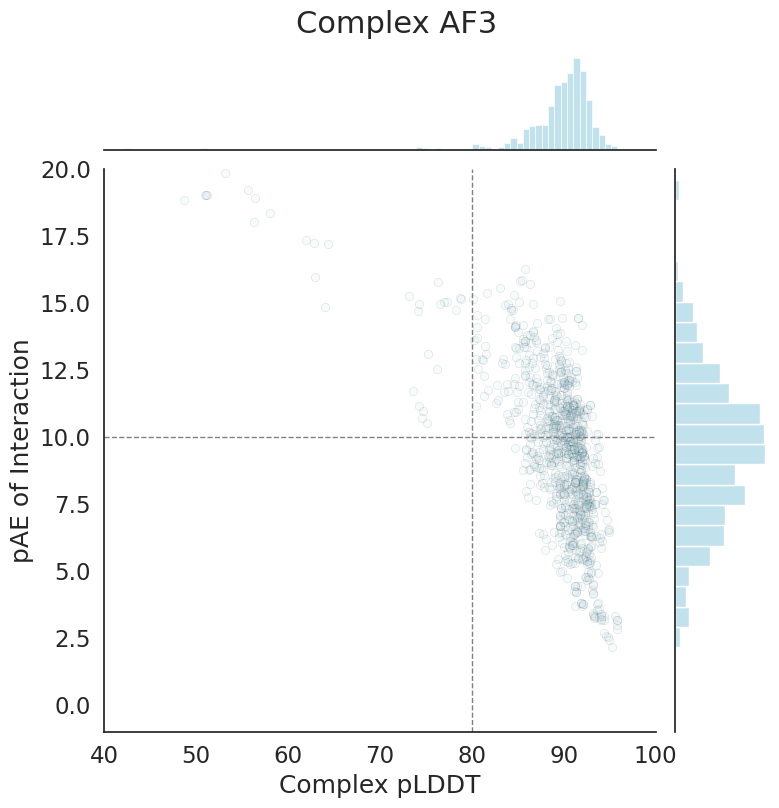

Number of outputs satisfying filter: 517 out of 945 predictions
fraction of outputs satisfying filter: 0.5470899470899471


In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Define the working directory and load the CSV file
working_dir = "/scratch_dir" + "/af3_complex_analysis/folding_out"
combined_csv_file = os.path.join(working_dir, "af3_data.csv")
filtered_csv_file = os.path.join(working_dir, "af3_folding_filtered.csv")
df = pd.read_csv(combined_csv_file , sep=',')
## check unique mpnn seqs
df['mpnn_seq_name'] = df['description'].apply(lambda x: x.removeprefix('pred.').split('_seed')[0])
df['diffusion_bb'] = df['mpnn_seq_name'].apply(lambda x: x.split("-atomized-bb-false")[0])

# Convert columns to numeric, coerce errors if there are any invalid values
df['complex_plddt'] = pd.to_numeric(df['complex_plddt'], errors='coerce')
df['pae_interface'] = pd.to_numeric(df['pae_interface'], errors='coerce')
# df = df[df.description.apply(lambda x: "qaqkqaq" in x.lower())]
x_point = 80
y_point = 10 ## 

# Set style
sns.set(style="white", font_scale=1.5)

# Create jointplot
g = sns.jointplot(
    data=df, 
    x='complex_plddt', 
    y='pae_interface', 
    kind='scatter', 
    color='lightblue', 
    edgecolor='black', 
    alpha=0.1,
    height=8,  # Size of the figure
)

# Add vertical and horizontal lines
g.ax_joint.axvline(x=x_point , color='gray', linestyle='dashed', linewidth=1)
g.ax_joint.axhline(y=y_point , color='gray', linestyle='dashed', linewidth=1)

# Set axis limits
g.ax_joint.set_xlim([40, 100])
g.ax_joint.set_ylim([-1, 20])

# Set labels and title
g.set_axis_labels('Complex pLDDT', 'pAE of Interaction', fontsize=18)
g.fig.suptitle('Complex AF3', y=1.02, fontsize=22)

plt.show()

# Count filtered output with additional conditions for RMSD values
condition = (
    (df['complex_plddt'] > x_point) &
    (df['pae_interface'] < y_point) 
)
satisfying_df = df[condition]
count = satisfying_df.shape[0]
print(f'Number of outputs satisfying filter: {count} out of {len(df)} predictions' )
print(f"fraction of outputs satisfying filter: {count/len(df)}")
# satisfying_df.to_csv(filtered_csv_file)


In [27]:
condition = (df["diffusion_bb"].apply(lambda x: x in bb_passing_monomer)) &\
            (df["complex_plddt"] > 85 ) &\
            (df['pae_interface'] < 10) 

mpnn_passes = df[condition].mpnn_seq_name.unique()
print("number of predictions satisfying complex and monomer:")

print("number of unique passing mpnn seqs")

print("number of unique bbs")
len(df[condition]), len(mpnn_passes), df[condition]["diffusion_bb"].nunique()

number of predictions satisfying complex and monomer:
number of unique passing mpnn seqs
number of unique bbs


(78, 22, 20)

## Catalytic site geometry

In [94]:
import os
import pandas as pd
import math
def generate_slurm_script(input_csv, template_pdb_dir, output_dir, log_dir, num_tasks, time, mem, rmsd_script, cif2pdb_script):
    slurm_script = f"""#!/bin/bash
#SBATCH -p cpu
#SBATCH --mem={mem}
#SBATCH -c 1
#SBATCH -J calculate_geometry
#SBATCH -o {log_dir}/process_data_%A_%a.out
#SBATCH -t {time}
#SBATCH -a 0-{num_tasks-1}

# Set variables
INPUT_CSV="{input_csv}"
TEMPLATE_PDB_DIR="{template_pdb_dir}"
OUTPUT_DIR="{output_dir}"

# Calculate chunk size and indices
TOTAL_ROWS=$(wc -l < "$INPUT_CSV")
CHUNK_SIZE=$(( (TOTAL_ROWS + SLURM_ARRAY_TASK_COUNT - 1) / SLURM_ARRAY_TASK_COUNT ))
START_INDEX=$(( SLURM_ARRAY_TASK_ID * CHUNK_SIZE ))
END_INDEX=$(( START_INDEX + CHUNK_SIZE ))

# Ensure END_INDEX doesn't exceed TOTAL_ROWS
if [ $END_INDEX -gt $TOTAL_ROWS ]; then
    END_INDEX=$TOTAL_ROWS
fi

# Run the Python script
/software/containers/PPI_design.sif {cif2pdb_script} "$INPUT_CSV" $START_INDEX $END_INDEX
/software/containers/PPI_design.sif {rmsd_script} "$INPUT_CSV" "$TEMPLATE_PDB_DIR" "${{OUTPUT_DIR}}/output_${{SLURM_ARRAY_TASK_ID}}.csv" $START_INDEX $END_INDEX
"""
    return slurm_script

def main():
    
    slurm_script = generate_slurm_script(
        input_csv,
        template_pdb_dir,
        output_dir,
        log_dir,
        num_tasks,
        time,
        mem,
        rmsd_script,
        cif2pdb_script
    )

    with open(output_slurm, "w") as f:
        f.write(slurm_script)

    print(f"SLURM script generated: {output_slurm}")
    print("You can now submit the job with:")
    print(f"sbatch {output_slurm}")

if __name__ == "__main__":
    working_directory = "/scratch_dir" + "/af3_complex_analysis/"
    input_csv = f'{working_directory}/folding_out/af3_data.csv' 
    template_pdb_dir = "/scratch_dir/filter_bb/filtered_bbs"
            
    log_dir = f'{working_directory}/log_catalytic_site_geometry' 
    os.makedirs(log_dir, exist_ok=True)
    output_dir = working_directory + '/rmsd_calculation_output'
    os.makedirs(output_dir , exist_ok=True)
    
    rows_per_task = 500
    num_tasks=math.ceil(len(pd.read_csv(input_csv))/rows_per_task)
    time='02:00:00'
    mem='1g' 
    rmsd_script = f'{os.getcwd()}/af3_complex_analysis/rmsd_calculation.py' 
    cif2pdb_script = f'{os.getcwd()}/af3_complex_analysis/convert_modify_pdb.py'
    output_slurm = f'{os.getcwd()}/af3_complex_analysis/run_array_job_rmsd_calculation.sh' 
    
    main()

### Concatenate results

SLURM script generated: /home/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/af3_complex_analysis/run_array_job_rmsd_calculation.sh
You can now submit the job with:
sbatch /home/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/af3_complex_analysis/run_array_job_rmsd_calculation.sh


In [104]:
rmsd_csv_path = "/scratch_dir/af3_complex_analysis/" + os.path.basename(input_csv).split('.csv')[0]+'_distance_rmsd_calculated.csv'
concatenating_command = f"cat {output_dir}/output_*.csv > {rmsd_csv_path}"
print('concatenate all processed csv files:\n',concatenating_command)
print('\nIf you see *~ files, simply check the .csv file and do rm *~')

concatenate all processed csv files:
 cat /net/scratch/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/af3_complex_analysis//rmsd_calculation_output/output_*.csv > /net/scratch/achen918/catalytic_binders/250615_motif_aminopeptidase_N_no_guideposting_free_diffusion/af3_complex_analysis/af3_data_distance_rmsd_calculated.csv

If you see *~ files, simply check the .csv file and do rm *~


In [105]:
df.iloc[0]["description"]

'4qhp_motif_astacin_substrate_strand_paircontiga_0_17_2-atomized-bb-false_t10_mpnnfr_cycle_0'

In [112]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_columns', None)

csv_complex = "/scratch_dir/af3_complex_analysis/af3_data_distance_rmsd_calculated.csv"
df_complex = pd.read_csv(csv_complex)
df = df_complex.copy()

pae_thresh = 10
enzyme_plddt_thresh = 82
rmsd_zinc_chelation_thresh = .5
zinc_sub_thresh = 4.8 # astacin af3 is 3.8
three_angle_thresh = 25
three_dihedral_thresh = 25
ca_rmsd_thresh = 3
sc_rmsd_thresh = 2 ## this includes 3 his and glu, tyrosine
opening_angle_thresh = 25
glu_to_coC_sum_thresh = 13 # astacin af3 ES complex is 4.7 + 5.6 = 10.3
tyr_to_coO_thresh = 5 # native astacin af3 ES complex is 2.1 
leaving_N_glu_O_thresh = 5 ## native astacin af3 ES complex is 3.9



df['rmsd_zinc_chelation'] = pd.to_numeric(df['rmsd_zinc_chelation'], errors='coerce')
df = df.dropna(subset=['rmsd_zinc_chelation'], how='any')
metrics = ['complex_plddt', 'per_chain_plddt_A',
       'per_chain_plddt_B', 'per_chain_plddt_C', 
       'pae_interface', 'chainA_len', 'chainB_len', 'zinc_his0', 'zinc_his1',
       'zinc_glu_chel_O1', 'zinc_glu_chel_O2', 'co_glu_base_1', 'co_glu_base_2', 'zinc_sub',
       'co_tyr', 'leaving_n_glu_1', 'leaving_n_glu_2', 'zinc_glu_chel_O',
       'rmsd_zinc_chelation', 'leaving_n_glu', 'angle_zinc_his_0',
       'angle_zinc_his_1', 'angle_zinc_glu', 'three_angle_rmsd',
       'dihedral_zinc_his_0', 'dihedral_zinc_his_1', 'dihedral_zinc_glu',
       'three_dihedral_rmsd', 'ca_rmsd', 'sc_rmsd', 'largest_opening_angle']

for column in metrics:

    df[column] = df[column].astype(float)

condition = (df['rmsd_zinc_chelation']<rmsd_zinc_chelation_thresh) & \
                (df['pae_interface']<pae_thresh) & \
                (df['zinc_sub']<zinc_sub_thresh) & \
                (df['per_chain_plddt_A']>enzyme_plddt_thresh) & \
            (df['three_angle_rmsd']<three_angle_thresh) & \
            (df['three_dihedral_rmsd']<three_dihedral_thresh) &\
            (df['ca_rmsd'] < ca_rmsd_thresh) &\
            (df['sc_rmsd'] < sc_rmsd_thresh) &\
            (df['largest_opening_angle'] > opening_angle_thresh) &\
            (df['co_glu_base_1'] + df['co_glu_base_2'] < glu_to_coC_sum_thresh) &\
            (df['co_tyr'] < tyr_to_coO_thresh) &\
            (df['leaving_n_glu'] < leaving_N_glu_O_thresh)


## check unique mpnn seqs
df['mpnn_seq_name'] = df['description'].apply(lambda x: x.split('_seed')[0])
df['diffusion_bb'] = df['mpnn_seq_name'].apply(lambda x: x.split("_mpnnfr_")[0])

## print number of predictions and chai seqs that pass filter
print(f"{len(df[condition])} predictions pass filter, {len(df[condition].mpnn_seq_name.unique())} mpnn seqs pass filter")
print(f" {len(df[condition].diffusion_bb.unique())} diffusion_bbs pass filter")

df_pass = df[condition].copy()
df_all = df.copy()

# Suppose `df` is your DataFrame and `condition` is your boolean Series (e.g., df['score'] > 0.7)
require_num_pass = 2
qualified_defs = get_descriptions_with_at_least_n_passes(df, condition, n=require_num_pass)
print(f"Number of qualified descriptions with {require_num_pass} out of 5 passes: {len(qualified_defs)}")


9 predictions pass filter, 5 mpnn seqs pass filter
 5 diffusion_bbs pass filter
Number of qualified descriptions with 2 out of 5 passes: 4


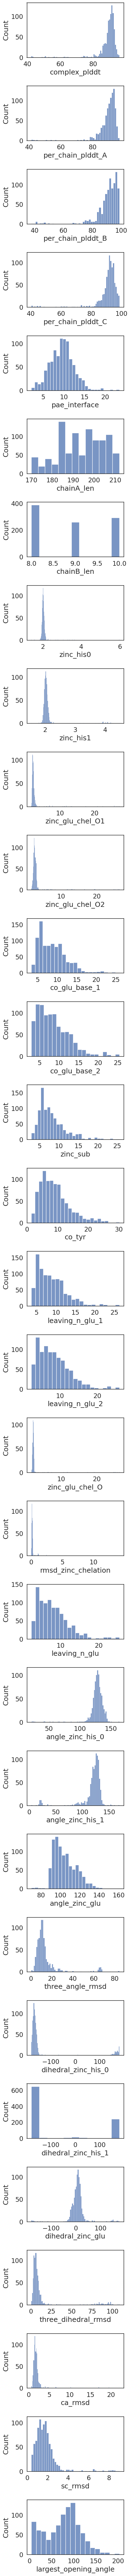

In [107]:
fig, axes = plt.subplots(len(metrics), 1, figsize = (5, 3*len(metrics)))
axes=axes.flatten()
for ax,metric in zip(axes,metrics):
    sns.histplot(data = df,
                x = metric,
                ax = ax)

plt.tight_layout()